<a href="https://colab.research.google.com/github/dtx14189/ML-domain-adaptation/blob/main/CPSC_381_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

### Imports and Setup

In [ ]:
!pip install scanpy

In [ ]:
!pip install anndata

In [ ]:
import scanpy as sc
import anndata as ad
from anndata import AnnData
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpreprocessing
import sklearn.metrics as skmetrics
import warnings, time
import matplotlib.pyplot as plt
import random
import umap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import Perceptron, LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading in Datasets

In [ ]:
# adata = ad.read_h5ad('/content/drive/MyDrive/Intro ML/Ulcerative Colitis/biopsy_RNA.h5ad')
filename = list(uploaded.keys())[0]
adata = ad.read_h5ad(filename)
adata.obs.rename(columns={'fine_annotations_MK_V4': 'celltype'}, inplace=True)

### Preprocesing

In [ ]:
freqs = (
    adata.obs
    .groupby(['condition','celltype'])
    .size()
    .unstack(fill_value=0)
)

# shared = freqs.columns[
#   (freqs.loc['HC'] >= 300) & (freqs.loc['UCV'] >= 300) & (freqs.loc['UCNB'] >= 300)
# ]

# Note: For our toy dataset (for memory purposes), we already presubset based on the cell types we used from the complete dataset.
#       The commented-out block of code above is what we ran on the complete dataset.
shared = freqs.columns[
  (freqs.loc['HC'] >= 0) & (freqs.loc['UCV'] >= 0) & (freqs.loc['UCNB'] >= 0)
]

shared_top = (
    freqs[shared]
    .sum(axis=0)
    .sort_values(ascending=False)
    .index
)

selected_celltypes = list(shared_top)

adata_sub = adata[adata.obs["celltype"].isin(selected_celltypes), :].copy()

adata_sub = adata_sub[adata_sub.obs["celltype"] != "01E-Plasma cells NOS"].copy()
adata_sub = adata_sub[adata_sub.obs["celltype"] != "03D-CD4 T NOS"].copy()
adata_sub = adata_sub[adata_sub.obs["celltype"] != "08E-MNP NOS"].copy()
adata_sub = adata_sub[adata_sub.obs["celltype"] != "11H-Stromal-fibroblast NOS"].copy()

UC_healthy = adata_sub[adata_sub.obs["condition"] == 'HC'].copy()
UC_disease = adata_sub[adata_sub.obs["condition"] != 'HC'].copy()

print(UC_healthy.obs["celltype"].nunique())
print(UC_disease.obs["celltype"].nunique())

<ipython-input-412-38d3ce67adf5>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['condition','celltype'])


12
12


In [ ]:
healthy_counts = UC_healthy.X.toarray()
healthy_target = UC_healthy.obs["celltype"].astype(str).values

# Do the same for the diseased (target distribution) cells
disease_counts = UC_disease.X.toarray()
disease_target = UC_disease.obs["celltype"].astype(str).values

X = healthy_counts
X_target = disease_counts

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(healthy_target)
y_target = label_encoder.transform(disease_target)

labels = label_encoder.classes_

# print(X.shape)
# print(y.shape)
# print(X_target.shape)

# print(np.unique(y), np.unique(y_t))

### Training-Validation Split (Test Set is Target Distribution)

In [ ]:
RANDOM_SEED = 42 # pick any integer you like
np.random.seed(RANDOM_SEED) # np
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) # PyTorch CPU
if torch.cuda.is_available(): # PyTorch GPU
    torch.cuda.manual_seed_all(RANDOM_SEED)

shuffled_indices = np.random.permutation(X.shape[0])
train_split_idx = int(0.80 * healthy_counts.shape[0])

# Choose the first 80% as training set, and the rest (20%) as validation
train_split_size = int(0.80 * X.shape[0])

train_indices = shuffled_indices[:train_split_size]
val_indices = shuffled_indices[train_split_size:]

# Select the examples from x and y to construct our training, validation, testing sets
X_train, y_train = X[train_indices, :], y[train_indices]
X_val, y_val = X[val_indices, :], y[val_indices]

### Principal Component Analysis

In [ ]:
dataset_components = [25, 50, 100, 200, 400]
dataset_name = 'Healthy Cells'

# Define empty lists to hold scores for training and validation
mse_scores_train = []
mse_scores_val = []

for components in dataset_components:
  print('***** Fitting PCA with {} components on {} dataset *****'.format(components, dataset_name))

  pca = PCA(n_components=components)
  pca.fit(X_train)

  Z_train = pca.transform(X_train)
  X_hat_train = pca.inverse_transform(Z_train)

  mse_score_train = skmetrics.mean_squared_error(X_train, X_hat_train)
  print('Training set mean squared error: {:.4f}'.format(mse_score_train))

  Z_val = pca.transform(X_val)
  X_hat_val = pca.inverse_transform(Z_val)

  mse_score_val =  skmetrics.mean_squared_error(X_val, X_hat_val)
  print('Validation set mean squared error: {:.4f}'.format(mse_score_val))

  mse_scores_train.append(mse_score_train)
  mse_scores_val.append(mse_score_val)

***** Fitting PCA with 25 components on Healthy Cells dataset *****
Training set mean squared error: 0.0674
Validation set mean squared error: 0.0674
***** Fitting PCA with 50 components on Healthy Cells dataset *****
Training set mean squared error: 0.0661
Validation set mean squared error: 0.0664
***** Fitting PCA with 100 components on Healthy Cells dataset *****
Training set mean squared error: 0.0639
Validation set mean squared error: 0.0648
***** Fitting PCA with 200 components on Healthy Cells dataset *****
Training set mean squared error: 0.0601
Validation set mean squared error: 0.0620
***** Fitting PCA with 400 components on Healthy Cells dataset *****
Training set mean squared error: 0.0538
Validation set mean squared error: 0.0573


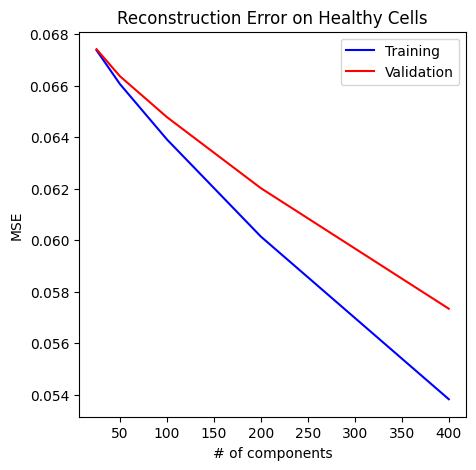

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(dataset_components, mse_scores_train, color='blue', label='Training')
ax.plot(dataset_components, mse_scores_val, color='red', label='Validation')

ax.set_title('Reconstruction Error on {}'.format(dataset_name))
ax.set_xlabel('# of components')
ax.set_ylabel('MSE')
ax.legend(loc='upper right')

### Highly Variable Gene Selection

In [ ]:
# Note: This is old code, just to show what we did
# sc.pp.highly_variable_genes(
#     adata,
#     flavor="seurat",
#     n_top_genes=100,
#     subset=True,
#     inplace=True
# )

### PCA (100 Components)

In [ ]:
pca = PCA(n_components=100)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_target = pca.transform(X_target)

In [ ]:
data = [X_train, y_train, X_val, y_val, X_target, y_target]
print(data[0].shape)

(20004, 100)


### Helper Functions for Generating Results

In [ ]:
class Results:
  def __init__(self, labels):
    self.__labels = labels

  def generate(self, model, model_name, data, plot=False, device=None):
    X_train, y_train, X_val, y_val, X_target, y_target = data

    if "Neural" in model_name:
      predictions_train = self.__compute_nn_predictions(model, X_train, device)
      predictions_val = self.__compute_nn_predictions(model, X_val, device)
      predictions_target = self.__compute_nn_predictions(model, X_target, device)
    else:
      predictions_train = model.predict(X_train)
      predictions_val = model.predict(X_val)
      predictions_target = model.predict(X_target)

    predictions = [predictions_train, predictions_val, predictions_target]
    ground_truths = [y_train, y_val, y_target]

    self.__print_scores(model_name, predictions, ground_truths)
    if plot:
      self.__display_confusion_matrix(predictions_target, y_target)
    if model_name != "Perceptron":
      if "Neural" in model_name:
        probabilities_target = self.__compute__nn_probabilities(model, X_target, device)
      else:
        probabilities_target = model.predict_proba(X_target)
      self.__nll_loss(model_name, probabilities_target, y_target)
      self.__f1_score(model_name, predictions_target, y_target)
      if plot:
        self.__display_roc_curve(probabilities_target, y_target)
        if "Domain Adaptation" in model_name:
          display_umap(probabilities_target, y_target)

  def __compute_nn_predictions(self, model, X, device):
    X_tensor = torch.from_numpy(X).float()
    X_tensor = X_tensor.to(device)
    model.eval()
    with torch.no_grad():
      logits = model(X_tensor)
      probabilities = torch.softmax(logits, dim=1)
      predicted_classes = torch.argmax(probabilities, dim=1)
    return predicted_classes.cpu().numpy()

  def __compute__nn_probabilities(self, model, X, device):
    X_tensor = torch.from_numpy(X).float()
    X_tensor = X_tensor.to(device)
    model.eval()
    with torch.no_grad():
      logits = model(X_tensor)
      probabilities = torch.softmax(logits, dim=1)
    return probabilities.cpu().numpy()

  def __print_scores(self, model_name, predictions, ground_truths):
    categories = ['Training', 'Validation', 'Target']
    for category, prediction, ground_truth in zip(categories, predictions, ground_truths):
      accuracy = skmetrics.accuracy_score(ground_truth, prediction)
      print("{} {} Accuracy: {:.4f}".format(model_name, category, accuracy))

  def __display_confusion_matrix(self, predictions, y_true):
    fig, ax = plt.subplots(figsize=(8, 8))
    confusion_matrix = skmetrics.confusion_matrix(y_true, predictions)
    confusion_matrix_plot = skmetrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=self.__labels
    )

    confusion_matrix_plot.plot(ax=ax)
    plt.xticks(fontsize=8, rotation=45, ha='right')
    plt.yticks(fontsize=8)

  def __display_roc_curve(self, probabilities, y_true):
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in range(len(self.__labels))]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    one_hot = skpreprocessing.label_binarize(y_true, classes=np.unique(y_true))

    for class_id, color, label in zip(range(len(labels)), colors, self.__labels):
      skmetrics.RocCurveDisplay.from_predictions(
              one_hot[:, class_id],
              probabilities[:, class_id],
              name='ROC curve for {}'.format(label),
              color=color,
              ax=ax
      )
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  def __nll_loss(self, model_name, probabilities, y_true, epsilon=1e-9):
    log_probs = np.log(probabilities + epsilon)
    nll = -np.sum(log_probs[np.arange(len(y_true)), y_true])
    mean_nll = nll / len(y_true)
    print("Negative Log Likelihood: {}".format(mean_nll))

  def __f1_score(self, model_name, predictions, y_true):
    score = skmetrics.f1_score(y_true, predictions, average='macro')
    print("F1 Score: {}".format(score))

def display_umap(predictions, ground_truths):
  reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
  embedding = reducer.fit_transform(predictions)

  plt.figure(figsize=(8, 6))
  scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=ground_truths, cmap='Spectral', s=10, alpha=0.8)
  plt.title('UMAP Projection of Predictions')
  plt.xlabel('UMAP 1')
  plt.ylabel('UMAP 2')
  plt.colorbar(scatter, label='True Label')

results = Results(labels)

### Mutliclass Perceptron

In [ ]:
class MulticlassPerceptron:
    '''
    Implementation of Multiclass Perceptron using one-vs-rest strategy
    '''

    def __init__(self):
        self.__weights = None
        self.__n_classes = None

    def __update(self, x, y, y_hat):
        '''
        Update weights for misclassified examples

        Arg(s):
            x : numpy.ndarray
                Feature vector of shape d x 1
            y : int
                Label/target (0, 1, 2, ... C-1)
            y_hat : int
                Predicted label (0, 1, 2, ... C-1)
        '''
        # weight update rule for multiclass case
        self.__weights[:, y] += x
        self.__weights[:, y_hat] -= x

    def fit(self, x, y, max_iter=100):
        '''
        Fit the multiclass perceptron to training data

        Arg(s):
            x : numpy.ndarray)
                Feature vector of shape N x d
            y : numpy.ndarray
                Label/target (0, 1, 2, ... C-1) of shape N,
            max_iter : int
                Maximum number of iterations
        '''
        x = x.T
        y = y.reshape(-1, 1).T

        n_features, n_samples = x.shape
        self.__n_classes = len(np.unique(y))

        # Initialize weights matrix of zeros with shape d+1 x C
        self.__weights = np.zeros((n_features + 1, self.__n_classes))

        # Append artificial coordinate (x0) to the data such that it is d+1 x N
        x = np.concatenate((x, -np.ones((1, n_samples))), axis=0)

        # Implement training loop
        for _ in range(max_iter):
            n_updates = 0

            # Process each sample
            for n in range(n_samples):
                # Calculate scores and make prediction for each class
                y_hat = np.argmax(np.matmul(self.__weights.T, x[:, n]))

                # Update if prediction is wrong
                if y_hat != y[0, n]:
                  self.__update(x[:, n], y[0, n], y_hat)
                  n_updates += 1

            # Break if no updates were made, e.g., check for convergence
            if n_updates == 0:
              break

    def predict(self, x):
        '''
        Make predictions on new data

        Arg(s):
            x : numpy.ndarray
                Features of shape N x d

        Returns:
            numpy.ndarray : Predicted class labels
        '''
        x = x.T

        n_features, n_samples = x.shape

        # Append artificial coordinate (x0) to the data
        x = np.concatenate((x, -np.ones((1, n_samples))), axis=0)

        # Implement prediction logic for multiclass case
        return np.argmax(np.matmul(self.__weights.T, x), axis=0)

    def score(self, x, y):
        '''
        Calculate prediction accuracy

        Arg(s):
            x : numpy.ndarray
                Features of shape N x d
            y : numpy.ndarray
                Label/target (0, 1, 2, ... C-1) of shape N,

        Returns:
            float : Accuracy score
        '''
        x = x.T
        y = y.reshape(-1, 1).T

        predictions = self.predict(x)
        return np.mean(predictions == y)


In [ ]:
# Takes 11 seconds
perceptron = MulticlassPerceptron()
perceptron.fit(X_train, y_train, max_iter=100)

Perceptron Training Accuracy: 0.8707
Perceptron Validation Accuracy: 0.8589
Perceptron Target Accuracy: 0.8329


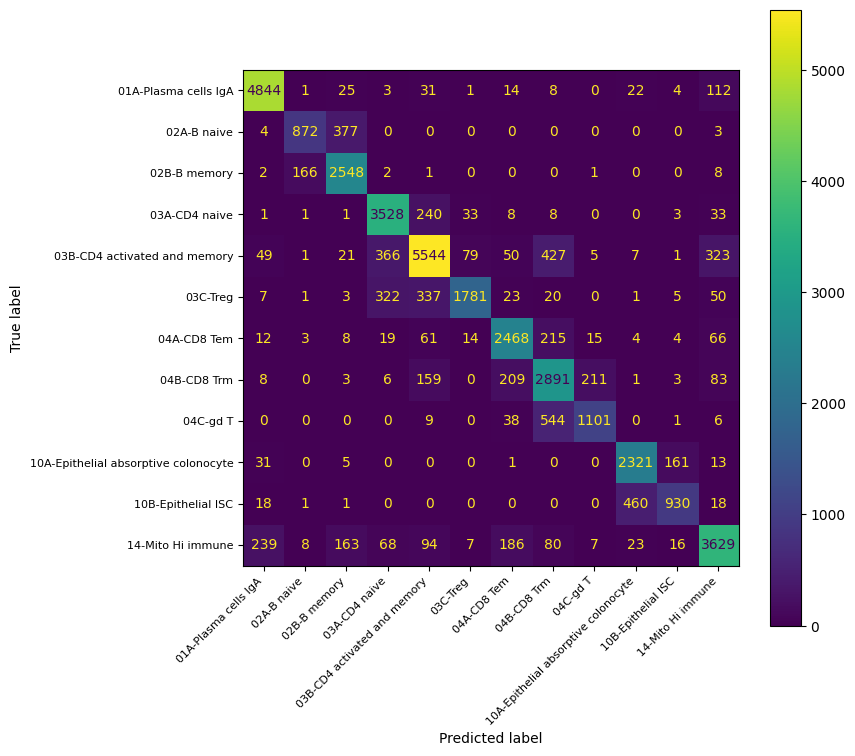

In [ ]:
results.generate(perceptron, 'Perceptron', data, plot=True)

### Logistic Regression with Regularization

In [ ]:
# Takes 58 seconds
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.3)
logistic_regression.fit(X_train, y_train)

LogisticRegression(C=0.3, max_iter=1000)

Logistic Regression (Regularization) Training Accuracy: 0.9063
Logistic Regression (Regularization) Validation Accuracy: 0.8782
Logistic Regression (Regularization) Target Accuracy: 0.8593
Negative Log Likelihood: 0.37817476081234536
F1 Score: 0.8437428731069923


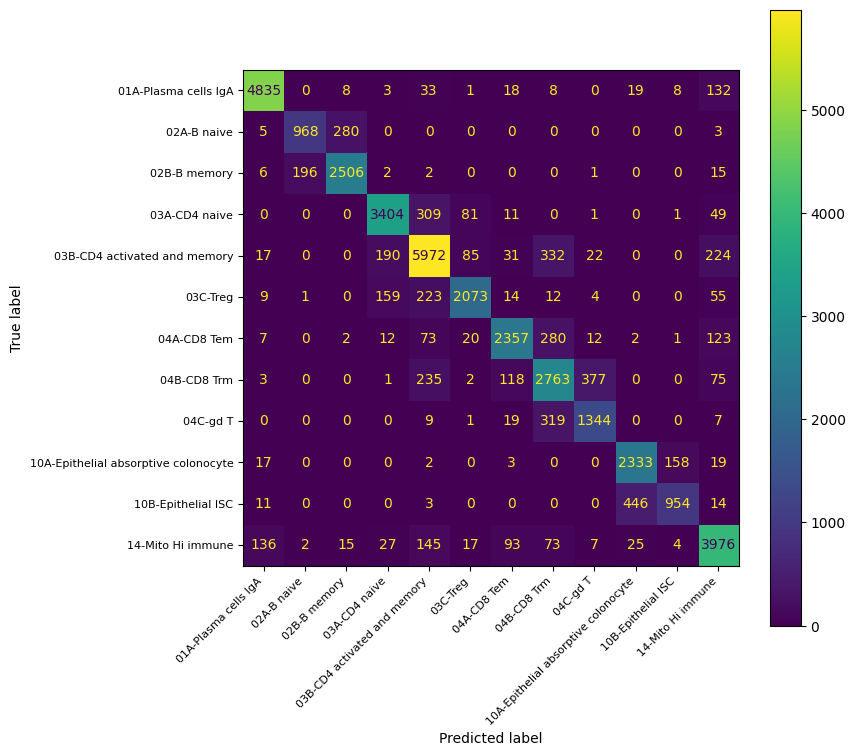

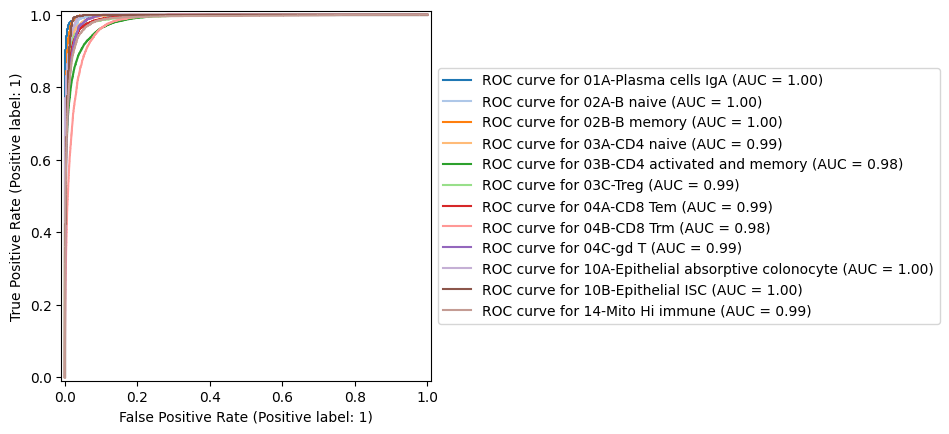

In [ ]:
results.generate(logistic_regression, 'Logistic Regression (Regularization)', data, plot=True)

### Kernel PCA

In [ ]:
kpca = KernelPCA(n_components=100, kernel='rbf', gamma=0.01, alpha=1.0, fit_inverse_transform=False)
kpca.fit(X_train)
X_train_kpca = kpca.transform(X_train)
X_val_kpca = kpca.transform(X_val)
X_target_kpca = kpca.transform(X_target)

In [ ]:
logistic_regression_kpca = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.5)
logistic_regression_kpca.fit(X_train_kpca, y_train)

LogisticRegression(C=0.5, max_iter=1000)

Logistic Regression (Kernel PCA) Training Accuracy: 0.8414
Logistic Regression (Kernel PCA) Validation Accuracy: 0.8329
Logistic Regression (Kernel PCA) Target Accuracy: 0.7970
Negative Log Likelihood: 0.6825451280092011
F1 Score: 0.7607577954178768


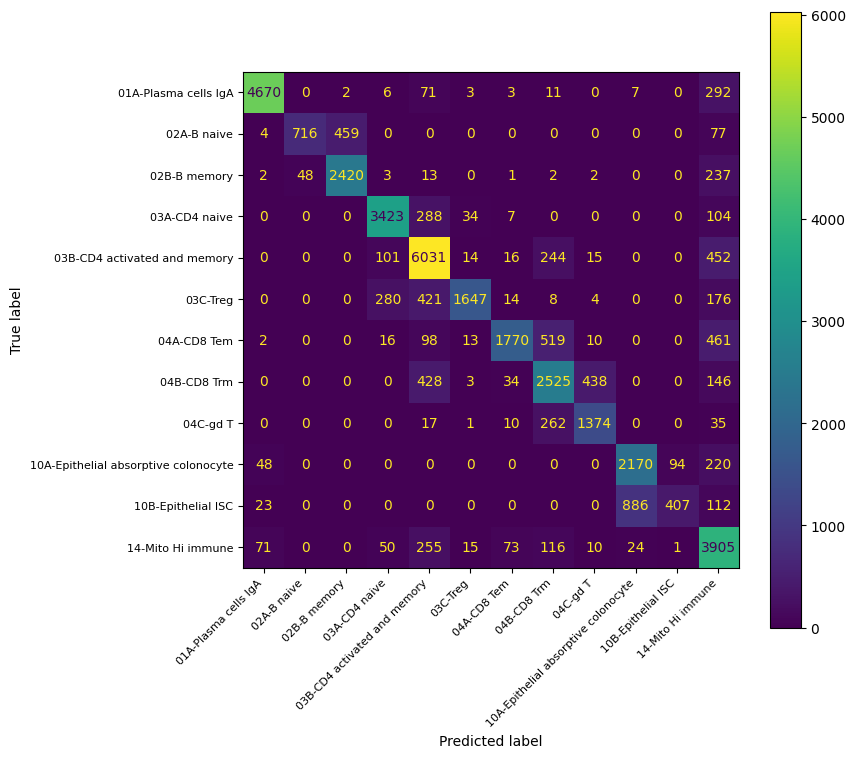

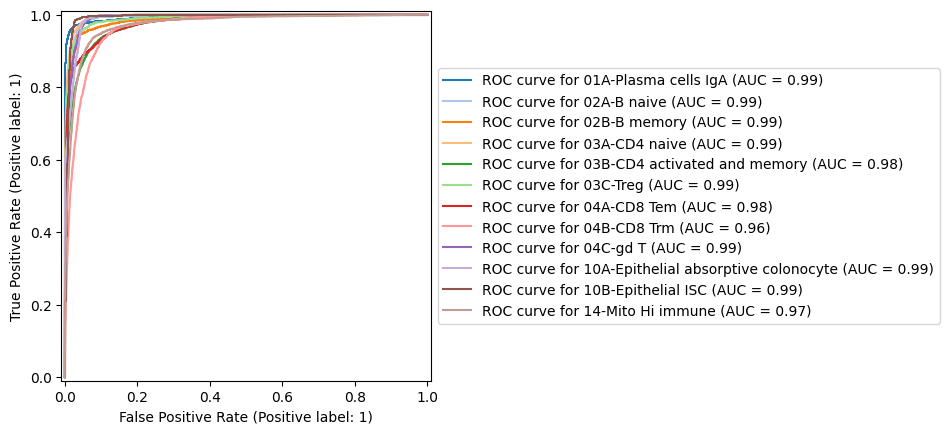

In [ ]:
data_kpca = [X_train_kpca, y_train, X_val_kpca, y_val, X_target_kpca, y_target]
results.generate(logistic_regression_kpca, 'Logistic Regression (Kernel PCA)', data_kpca, plot=True)

### Neural Network

In [ ]:
def make_loader(X_split, y_split, batch_size=128, shuffle=False, num_workers=0):
    dataset = TensorDataset(
        torch.from_numpy(X_split),
        torch.from_numpy(y_split)
    )
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
# Build data loader for torch
print(X_train.shape)
train_loader = make_loader(X_train, y_train, batch_size=64, shuffle=True, num_workers=2)
val_loader = make_loader(X_val, y_val, batch_size=64)
target_loader = make_loader(X_target, y_target, batch_size=64)

(20004, 100)


In [ ]:
# Define model specifications
class CellTypeNet(nn.Module):
    def __init__(self, in_feats, n_classes, hidden=1024,
                 num_hidden_layers=4, dropout=0.2):
        super().__init__()

        # build up the layers
        layers = []
        prev_feats = in_feats
        next_feats = hidden
        for i in range(num_hidden_layers):
            layers += [
                nn.Linear(prev_feats, next_feats),
                nn.BatchNorm1d(next_feats),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout)
            ]
            prev_feats = next_feats
            # next_feats = next_feats // 2
            next_feats = next_feats

        # Final layer for classification
        layers += [nn.Linear(prev_feats, n_classes)]
        self.net = nn.Sequential(*layers)

        # self.net = nn.Sequential(
        #     nn.Linear(in_feats, hidden),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(dropout),
        #     nn.Linear(hidden, hidden),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(dropout),
        #     nn.Linear(hidden, n_classes)
        # )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Check if GPUs available:
print(torch.cuda.is_available())

neural_network = CellTypeNet(
    in_feats=X_train.shape[1],
    n_classes=pd.Series(y).nunique(),
    hidden=1024,
    num_hidden_layers=3,
    dropout=0.2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_network.to(device)

# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=5e-3)
optimizer = torch.optim.SGD(neural_network.parameters(), lr=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.99
)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Training loop
n_epochs = 60
for epoch in range(1, n_epochs+1):
    neural_network.train()
    total_loss = 0
    for i, (cells, labels) in enumerate(train_loader):
        # move data to GPU
        cells = cells.to(device)
        labels = labels.to(device)

        # forward pass through model
        logits = neural_network(cells.float())

        # Clear out the previous gradients
        optimizer.zero_grad()

        # Compute the loss function
        loss = loss_func(logits, labels)

        # Update parameters by backpropagation
        loss.backward()
        optimizer.step() # update weights

        total_loss += loss.item()
    mean_loss = total_loss / len(train_loader)

    # Monitor the training loss and lr every 50 (as well as validation loss)
    if (epoch % 2 == 0):
        current_lr = scheduler.get_last_lr()[0]

        # Monitor Validation Loss
        neural_network.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                logits = neural_network(x_val.float())
                batch_loss = loss_func(logits, y_val)
                val_loss += batch_loss.item() * x_val.size(0)

        # average over all validation samples
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch:3d} | Training Loss: {mean_loss:.4f} | Validation Loss: {val_loss:.4f} | Learning Rate: {current_lr:.1e}")

    scheduler.step()

True
Epoch   2 | Training Loss: 1.2256 | Validation Loss: 1.0183 | Learning Rate: 5.0e-04
Epoch   4 | Training Loss: 0.8566 | Validation Loss: 0.7278 | Learning Rate: 5.0e-04
Epoch   6 | Training Loss: 0.6884 | Validation Loss: 0.5977 | Learning Rate: 4.9e-04
Epoch   8 | Training Loss: 0.5936 | Validation Loss: 0.5210 | Learning Rate: 4.9e-04
Epoch  10 | Training Loss: 0.5379 | Validation Loss: 0.4705 | Learning Rate: 4.9e-04
Epoch  12 | Training Loss: 0.4947 | Validation Loss: 0.4359 | Learning Rate: 4.9e-04
Epoch  14 | Training Loss: 0.4690 | Validation Loss: 0.4155 | Learning Rate: 4.9e-04
Epoch  16 | Training Loss: 0.4460 | Validation Loss: 0.3974 | Learning Rate: 4.9e-04
Epoch  18 | Training Loss: 0.4259 | Validation Loss: 0.3830 | Learning Rate: 4.9e-04
Epoch  20 | Training Loss: 0.4139 | Validation Loss: 0.3718 | Learning Rate: 4.9e-04
Epoch  22 | Training Loss: 0.4026 | Validation Loss: 0.3632 | Learning Rate: 4.8e-04
Epoch  24 | Training Loss: 0.3946 | Validation Loss: 0.3542 

Neural Network Training Accuracy: 0.9046
Neural Network Validation Accuracy: 0.8784
Neural Network Target Accuracy: 0.8618
Negative Log Likelihood: 0.3633539080619812
F1 Score: 0.8463233728636604


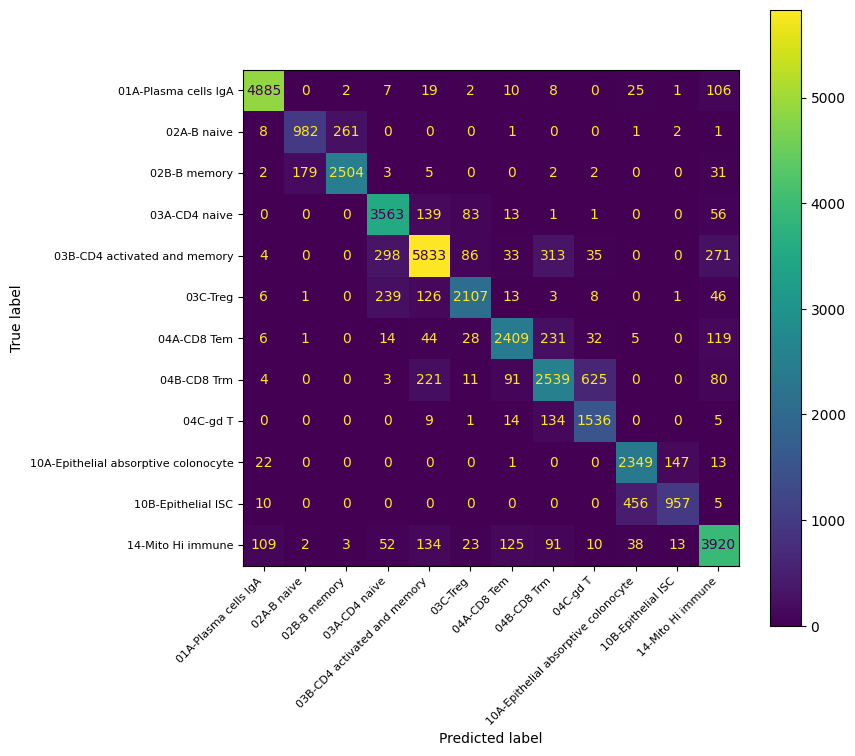

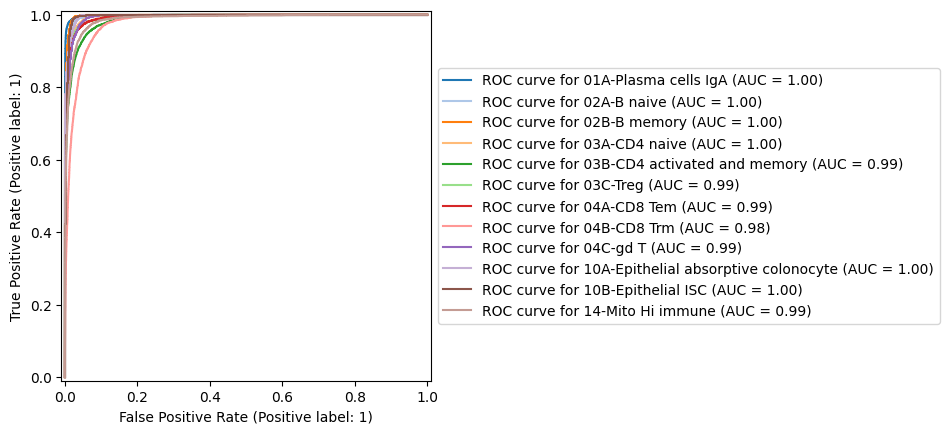

In [ ]:
results.generate(neural_network, "Neural Network", data, plot=True, device=device)

### Neural Network with Uncertainty Regularization for Domain Adaptation

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Suppose your training labels are in y_train (shape [N], class indices)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

In [ ]:
def domain_adapt_loss(logits_s, labels_s,
                      logits_t, lambda_ent=0.1):

    # Supervised CE loss
    # loss_ce = F.cross_entropy(logits_s, labels_s, reduction='mean', weight=class_weights)
    loss_ce = F.cross_entropy(logits_s, labels_s, reduction='mean')

    # Entropy penalty on target

    # 1. Defining the probability distribution for each cell in target
    p_t = F.softmax(logits_t, dim=1)
    # 2. Collapse down the dimensions with information entropy
    ent = -torch.sum(p_t * torch.log(p_t + 1e-5), dim=1)
    loss_ent = ent.mean()

    # Combine the loss terms
    return loss_ce + lambda_ent * loss_ent

In [ ]:
print(torch.cuda.is_available())

neural_network_DA = CellTypeNet(
    in_feats=X_train.shape[1],
    n_classes=pd.Series(y).nunique(),
    hidden=4096,
    num_hidden_layers=3,
    dropout=0.2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_network_DA.to(device)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.SGD(neural_network_DA.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=5, gamma=0.99
)

loss_func = nn.CrossEntropyLoss()

n_epochs = 60
for epoch in range(1, n_epochs+1):
    neural_network_DA.train()
    total_loss = 0

    # Define iterables for the source distribution
    # and the target distributions
    source_iter = iter(train_loader)
    target_iter = iter(target_loader)

    # assume same # of source & target batches, or handle StopIteration
    for _ in range(len(train_loader)):

        # Get the in distribution samples
        cells_s, labels_s = next(source_iter)
        # Get the out of distribution samples
        cells_t, _ = next(target_iter)

        # Move to the GPU
        cells_s, labels_s = cells_s.to(device), labels_s.to(device)
        cells_t = cells_t.to(device)

        # forward pass through source cells
        logits_s = neural_network_DA(cells_s.float())
        # forward pass through the target cells
        logits_t = neural_network_DA(cells_t.float())

        # clear gradients
        optimizer.zero_grad()

        # compute the loss
        loss = domain_adapt_loss(logits_s, labels_s, logits_t)
        # loss = loss_func(logits_s, labels_s)

        # update parameters via backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate total loss for the epoch
        total_loss = total_loss + loss.item()

    # Compute average loss for the epoch
    mean_loss = total_loss / len(train_loader)

    if epoch % 2 == 0:
        # print(f"Epoch {epoch:3d} | Mean Loss: {mean_loss:.4f}")

        current_lr = scheduler.get_last_lr()[0]

        # Monitor Validation Loss
        neural_network_DA.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                logits = neural_network_DA(x_val.float())
                batch_loss = loss_func(logits, y_val)
                val_loss += batch_loss.item() * x_val.size(0)

        # average over all validation samples
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch:3d} | Training Loss: {mean_loss:.4f} | Validation Loss: {val_loss:.4f} | Learning Rate: {current_lr:.1e}")

    scheduler.step()

True
Epoch   2 | Training Loss: 0.7972 | Validation Loss: 0.5471 | Learning Rate: 5.0e-04
Epoch   4 | Training Loss: 0.5470 | Validation Loss: 0.4173 | Learning Rate: 5.0e-04
Epoch   6 | Training Loss: 0.4643 | Validation Loss: 0.3720 | Learning Rate: 4.9e-04
Epoch   8 | Training Loss: 0.4214 | Validation Loss: 0.3451 | Learning Rate: 4.9e-04
Epoch  10 | Training Loss: 0.3966 | Validation Loss: 0.3324 | Learning Rate: 4.9e-04
Epoch  12 | Training Loss: 0.3783 | Validation Loss: 0.3266 | Learning Rate: 4.9e-04
Epoch  14 | Training Loss: 0.3602 | Validation Loss: 0.3151 | Learning Rate: 4.9e-04
Epoch  16 | Training Loss: 0.3535 | Validation Loss: 0.3123 | Learning Rate: 4.9e-04
Epoch  18 | Training Loss: 0.3434 | Validation Loss: 0.3081 | Learning Rate: 4.9e-04
Epoch  20 | Training Loss: 0.3363 | Validation Loss: 0.3032 | Learning Rate: 4.9e-04
Epoch  22 | Training Loss: 0.3318 | Validation Loss: 0.3041 | Learning Rate: 4.8e-04
Epoch  24 | Training Loss: 0.3200 | Validation Loss: 0.2986 

Neural Network (Domain Adaptation) Training Accuracy: 0.9335
Neural Network (Domain Adaptation) Validation Accuracy: 0.8896
Neural Network (Domain Adaptation) Target Accuracy: 0.8687
Negative Log Likelihood: 0.3506651222705841
F1 Score: 0.8546390281878727


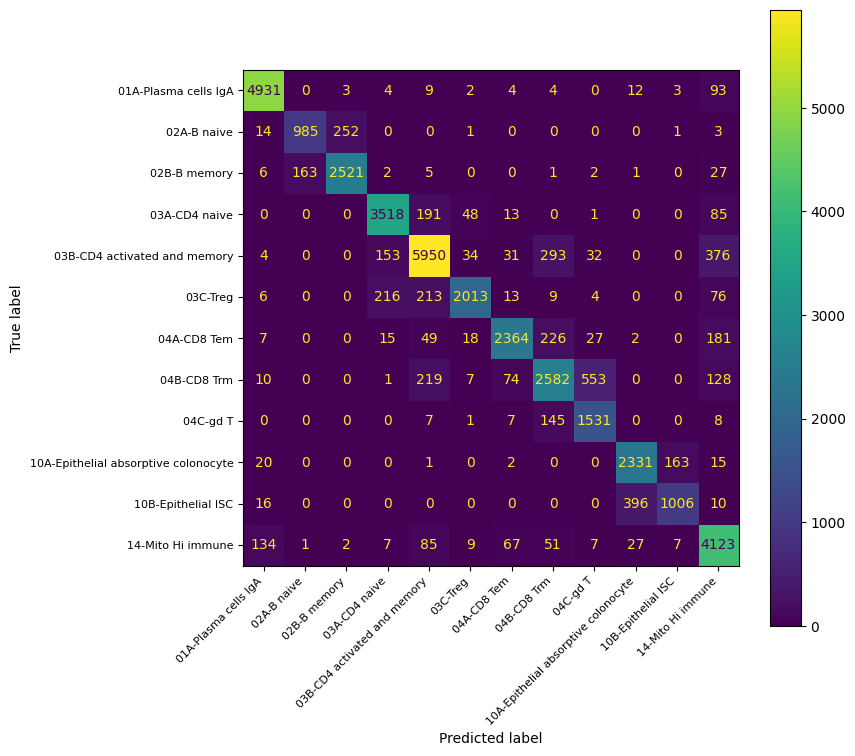

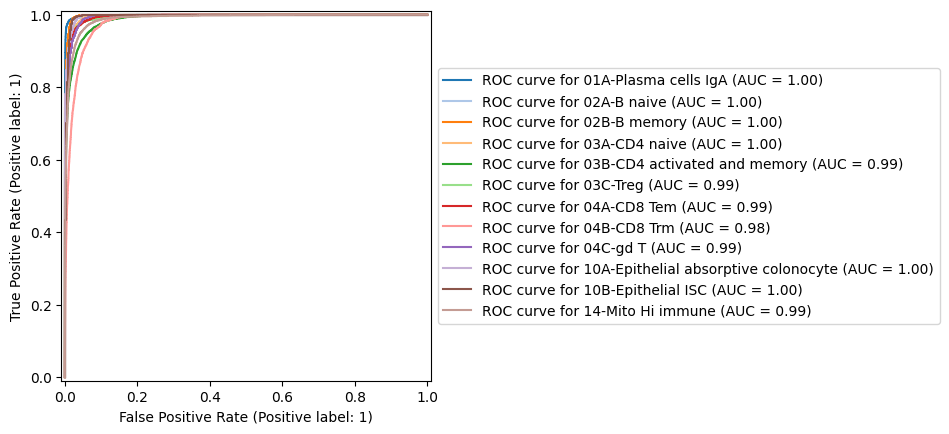

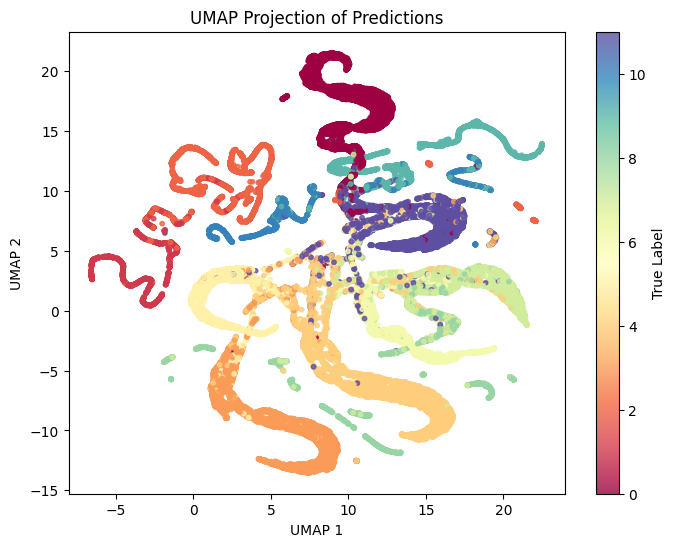

In [ ]:
results.generate(neural_network_DA, "Neural Network (Domain Adaptation)", data, plot=True, device=device)